The following code starts the multi client script in the background and records load balancer metrics at regular intervals to analyse. In this example the load balancer is using the weighted round robin algorithm with weights inversely proportional to each server's simulated latency.

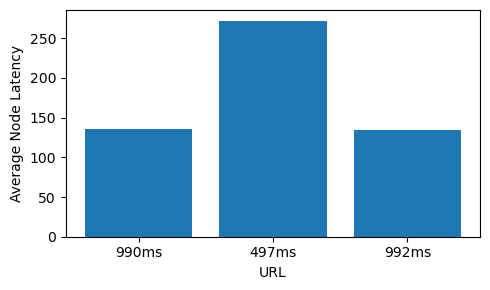

None

'Average Overall Latency: 826ms'

In [19]:
import collections
import requests
import subprocess
import sys
import time

from IPython.display import clear_output, display
import matplotlib
import matplotlib.pyplot as plt

LB_URL = "http://localhost:8080"
REQUEST_COUNT = 1
CLIENT_COUNT = 5
METRICS_BUFFER_MAXLEN = 30
METRIC_INTERVAL = 5

# Run multi client script in background process
multi_client_process = subprocess.Popen(["go", "run", "../demo/multi-client/", LB_URL, str(REQUEST_COUNT), str(CLIENT_COUNT)],
                                        stdout=sys.stdout)
print("Multi client simulation started. See Jupyter's stdout for logs")

# Store most recent metrics
metrics_buffer = collections.deque(maxlen=METRICS_BUFFER_MAXLEN)

# While multi client script process is still running
print("Started fetching metrics at a regular interval")
while multi_client_process.poll() is None:
    
    # Fetch metrics
    response = requests.get(LB_URL + "/metrics")

    # Save metric data
    metrics_buffer.append(response.json())

    time.sleep(METRIC_INTERVAL)

print("Multi client simulation finished")
clear_output()


# Set width and height of figure
plt.rcParams["figure.figsize"] = [5, 3]

figure, axis = plt.subplots(nrows=1, ncols=1)

def plot_request_count_bar_chart(axes: matplotlib.axes.Axes):
    """Plot request count bar chart.

    Args:
        axes (plt.axes.Axes): The axes object to plot to.
    
    """
    averageNodeLatencies = [server_node_metric["averageLatency"] for server_node_metric in metrics_buffer[len(metrics_buffer) - 1]["serverNodeMetrics"]]
    request_counts = [server_node_metric["requestCount"] for server_node_metric in metrics_buffer[len(metrics_buffer) - 1]["serverNodeMetrics"]]
    
    axes.set_xlabel("URL")
    axes.set_ylabel("Average Node Latency")
    axes.bar(averageNodeLatencies, request_counts)

plot_request_count_bar_chart(axis)

plt.tight_layout()
display(plt.show())

display(f"Average Overall Latency: {metrics_buffer[len(metrics_buffer) - 1]['overallLatency']}")
